# 11 Analysis Pipeline

**Objectives:**
* don't use test data for feature selection step
* perhaps more narrow hyperparameter distributions

In [41]:
import pandas as pd
import numpy as np
import os
import pickle
import itertools

from numpy import ma  # masked array
from pandas.plotting import parallel_coordinates, andrews_curves, radviz

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

from scipy.stats.distributions import uniform as sp_uni, randint as sp_int

import seaborn as sns

from boruta import BorutaPy

from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, GradientBoostingRegressor, GradientBoostingClassifier
from sklearn.model_selection import RandomizedSearchCV, cross_val_score, ShuffleSplit
from sklearn.ensemble.partial_dependence import partial_dependence, plot_partial_dependence
from sklearn.metrics import confusion_matrix
from sklearn.manifold import TSNE
from sklearn.pipeline import Pipeline

from umap import UMAP

import lime 
from lime.lime_tabular import LimeTabularExplainer

import sklearn.datasets
from lime.lime_tabular import LimeTabularExplainer

sns.set(style="whitegrid")

In [2]:
class EarlyStopMonitor:

    def __init__(self, window_length=25):
        self.window_length = window_length

    def window_boundaries(self, current_round):        
        lo = max(0, current_round - self.window_length + 1)
        hi = current_round + 1

        return lo, hi

    def __call__(self, current_round, regressor, _):        
        if current_round >= self.window_length - 1:
            lo, hi = self.window_boundaries(current_round)
            
            do_stop = np.mean(regressor.oob_improvement_[lo: hi]) < 0
            
            if do_stop:
                print('stopped after rounds: {}'.format(current_round))
            
            return do_stop
        else:
            return False

---

# Load the data

In [3]:
results_wd = '10_results/'

In [4]:
wd = '/media/tmo/data/work/datasets/02_ST'

logcpm_path = wd + '/ashley_21.03.2018/logcpm_merge_20180212.pickle'
meta_path = wd + '/meta/meta.parquet'

In [5]:
%%time
meta_df = pd.read_parquet(meta_path)

CPU times: user 140 ms, sys: 244 ms, total: 384 ms
Wall time: 209 ms


In [6]:
%%time
logcpm_df = pickle.load(open(logcpm_path, "rb"))

logcpm_df.index.name = 'spot_UID'
logcpm_df.reset_index(inplace=True)
logcpm_df.rename(columns={'sampleID': 'slide_ID'}, inplace=True)

CPU times: user 16 s, sys: 7.22 s, total: 23.2 s
Wall time: 23.2 s


In [7]:
st_df = logcpm_df.merge(meta_df, how='inner', on=['spot_UID', 'slide_ID'])

In [8]:
st_df['slide_ID'] = st_df['slide_ID'].astype('category', copy=False)
st_df['GT']       = st_df['GT'].astype('category', copy=False)
st_df['age']      = st_df['age'].astype('category', copy=False)
st_df['age_GT']   = st_df['age_GT'].astype('category', copy=False)

In [9]:
n_genes = 46454
gene_columns = st_df.columns[1:n_genes+1]

* merge with satellite tables

In [10]:
region_levels_df = pd.read_csv('region_levels.csv', sep=',', keep_default_na=False)

In [11]:
final_meta_df = pd.read_csv('final_metadata_scores.tsv', sep='\t', index_col=0)
final_meta_df.index.name = 'spot_UID'
final_meta_df.reset_index(inplace=True)
final_meta_df = final_meta_df[final_meta_df['AB'].notna()][['spot_UID', 'AB']]

### Log transform AB index
* the AB index is very skewed, this is not ideal for ML algorithm to regress upon
* use a masked array to compute natural log of AB index

cfr. **Jaak Simm**:
> if it is not transformed, the skewness will result in the fact that larger (absolute) deviations will be focused by the model
so lot of focus will be put into these high end values

In [12]:
final_meta_df['log_AB'] = ma.log(final_meta_df['AB'].as_matrix())

* let's check the distributions after log transform
* much nicer (Gaussian-like)
* there is some bimodality going on (could be batch effect, to investigate)

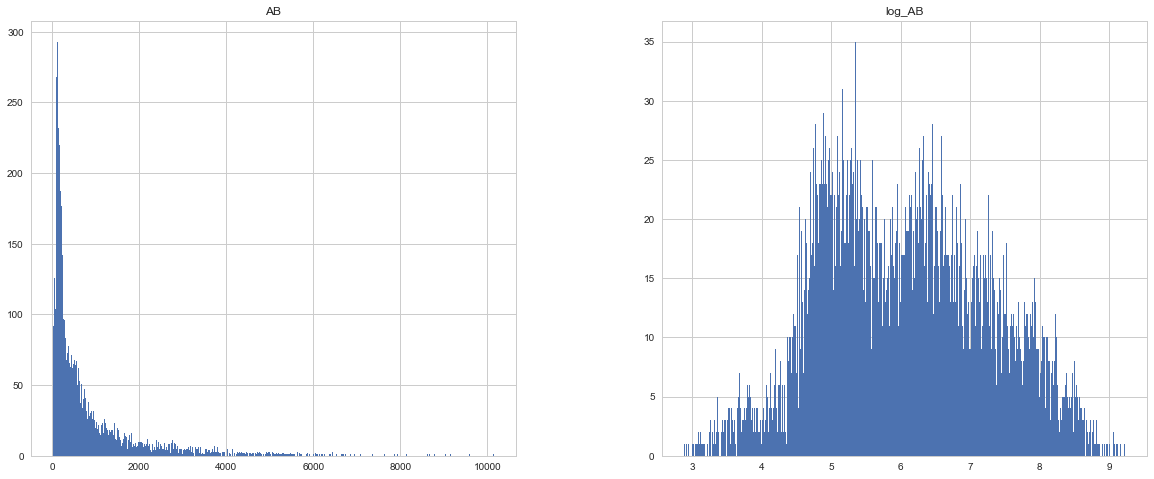

In [13]:
final_meta_df[final_meta_df['log_AB'] > 0][['AB', 'log_AB']].hist(bins=500, figsize=(20, 8))
plt.show()

In [14]:
full_df = st_df \
    .merge(region_levels_df, on='Region_predict') \
    .merge(final_meta_df, on='spot_UID')

In [15]:
expression_df = full_df[gene_columns]

In [16]:
expression_df.head()

,-343C11.2,00R_AC107638.2,0610005C13Rik,0610006L08Rik,0610007P14Rik,0610009B22Rik,0610009E02Rik,0610009L18Rik,0610009O20Rik,0610010F05Rik,...,n-R5s90,n-R5s92,n-R5s93,n-R5s94,n-R5s95,n-R5s96,n-R5s97,n-R5s98,n-TSaga9,n-TStga1
0,2.982974,2.982974,2.982974,2.982974,2.982974,2.982974,4.984943,2.982974,2.982974,2.982974,...,2.982974,2.982974,2.982974,2.982974,2.982974,2.982974,2.982974,2.982974,2.982974,2.982974
1,2.982974,2.982974,2.982974,2.982974,6.827059,5.924174,2.982974,2.982974,2.982974,2.982974,...,2.982974,2.982974,2.982974,2.982974,2.982974,2.982974,2.982974,2.982974,2.982974,2.982974
2,2.982974,2.982974,2.982974,2.982974,2.982974,5.609164,2.982974,2.982974,5.609164,2.982974,...,2.982974,2.982974,2.982974,2.982974,2.982974,2.982974,2.982974,2.982974,2.982974,2.982974
3,2.982974,2.982974,2.982974,2.982974,7.661385,2.982974,2.982974,2.982974,5.157746,5.157746,...,2.982974,2.982974,2.982974,2.982974,2.982974,2.982974,2.982974,2.982974,2.982974,2.982974
4,2.982974,2.982974,2.982974,2.982974,6.738947,6.738947,2.982974,2.982974,2.982974,7.432553,...,2.982974,2.982974,2.982974,2.982974,2.982974,2.982974,2.982974,2.982974,2.982974,2.982974


In [17]:
log_AB_df = full_df[['log_AB']]

In [18]:
# assert expression_df.shape == (10327, 46454) 
assert expression_df.shape == (10324, 46454)  # 3 less = damaged spots

---

# Prepare data

---

# Pipeline implementation

* make an composition of steps that should be cross-validated together
* do feature selection also on training data, never touch test

In [19]:
from tempfile import mkdtemp

def fit_pipeline(X_train, y_train, 
                 seed=666,                 
                 cache_dir='11_cache'):
    
    boruta_estimator = RandomForestRegressor(n_jobs=-1, 
                                             n_estimators=1000, 
                                             max_features='sqrt', 
                                             random_state=seed)
    
    boruta_selector = BorutaPy(estimator=boruta_estimator,
                               max_iter=100,                               
                               verbose=0,
                               random_state=seed)
    
    deep_gbm = GradientBoostingRegressor(learning_rate=0.01,
                                         n_estimators=10000,
                                         subsample=0.9,
                                         max_depth=12,
                                         max_features=0.2,
                                         random_state=seed)
    
    pipeline = Pipeline(memory=cache_dir,
                        steps=[('boruta', boruta_selector),
                               ('deep_gbm', deep_gbm)])
        
    pipeline.fit(X_train, y_train, **{'deep_gbm__monitor': EarlyStopMonitor()})
    
    return pipeline

In [20]:
level_01_regions = region_levels_df.Level_01.unique()

def filter_spots(df,
                 level_01_region=None,
                 genotype=None):
    
    result_df = df
    
    if level_01_region:
        assert level_01_region in level_01_regions        
        result_df = result_df[result_df['Level_01'] == level_01_region]
        
    if genotype:
        assert genotype in ['WT', 'KI']
        result_df = result_df[result_df['GT'] == genotype]
        
    return result_df

In [21]:
def split_train_test(df,
                     groups=None,
                     splitter=ShuffleSplit(n_splits=1, test_size=0.15, random_state=42)):
    
    train_idx, test_idx = list(splitter.split(df, groups=groups))[0]
    
    return train_idx, test_idx

In [22]:
def make_datasets(df, level_01_region, genotype, groups=None):
    filtered_df = filter_spots(df, level_01_region, genotype)
    
    train_idx, test_idx = split_train_test(filtered_df, groups)
    
    X_train = filtered_df[gene_columns].iloc[train_idx]
    y_train = filtered_df['log_AB'].iloc[train_idx]
    
    X_test = filtered_df[gene_columns].iloc[test_idx]
    y_test = filtered_df['log_AB'].iloc[test_idx]
    
    return (X_train, y_train), (X_test, y_test)

In [23]:
def important_genes(pipeline):
    boruta_selector = pipeline.steps[0][1]
    deep_sgbm = pipeline.steps[1][1]
    
    boruta_genes = list(gene_columns[boruta_selector.support_])
    
    important_genes_df = pd.DataFrame({'gene': boruta_genes,
                                       'importance': deep_sgbm.feature_importances_}).sort_values(by='importance', ascending=False)
    
    return boruta_genes, important_genes_df    

In [24]:
def plot_test_predictions(pipeline, X_test, y_test):
    predictions_df = pd.DataFrame({'predict': pipeline.predict(X_test.as_matrix()),
                                   'actual': y_test.values.ravel()})
    
    sns.jointplot("actual", "predict", data=predictions_df, kind="reg", color="g", size=7)
    plt.show()

In [50]:
def plot_pdp(pipeline, X_train, top=24):
    top_genes = important_genes(pipeline)[1]['gene'][:top]
    
    boruta_selector = pipeline.steps[0][1]
    deep_sgbm = pipeline.steps[1][1]
    
    boruta_genes = list(gene_columns[boruta_selector.support_])
    
    gene_indices = [boruta_genes.index(gene) for gene in top_genes]
    
    plot_partial_dependence(deep_sgbm,
                            X=X_train[boruta_genes],
                            features=gene_indices,
                            feature_names=boruta_genes,
                            grid_resolution=100,
                            n_jobs=1, figsize=(12, 32))
    
    plt.show()

---

# **<< KI ONLY >>**



---

# CX

In [25]:
(CX_KI_X_train, CX_KI_y_train), (CX_KI_X_test, CX_KI_y_test) = make_datasets(full_df, 'CX', 'KI')

In [ ]:
%%time
CX_KI_pipeline = fit_pipeline(CX_KI_X_train.as_matrix(), 
                              CX_KI_y_train.values.ravel())

In [27]:
CX_KI_boruta_genes, CX_KI_important_genes_df = important_genes(CX_KI_pipeline)

In [83]:
CX_KI_important_genes_df.to_csv('11_results/CX_KI_important_genes.tsv', sep='\t', index=None)

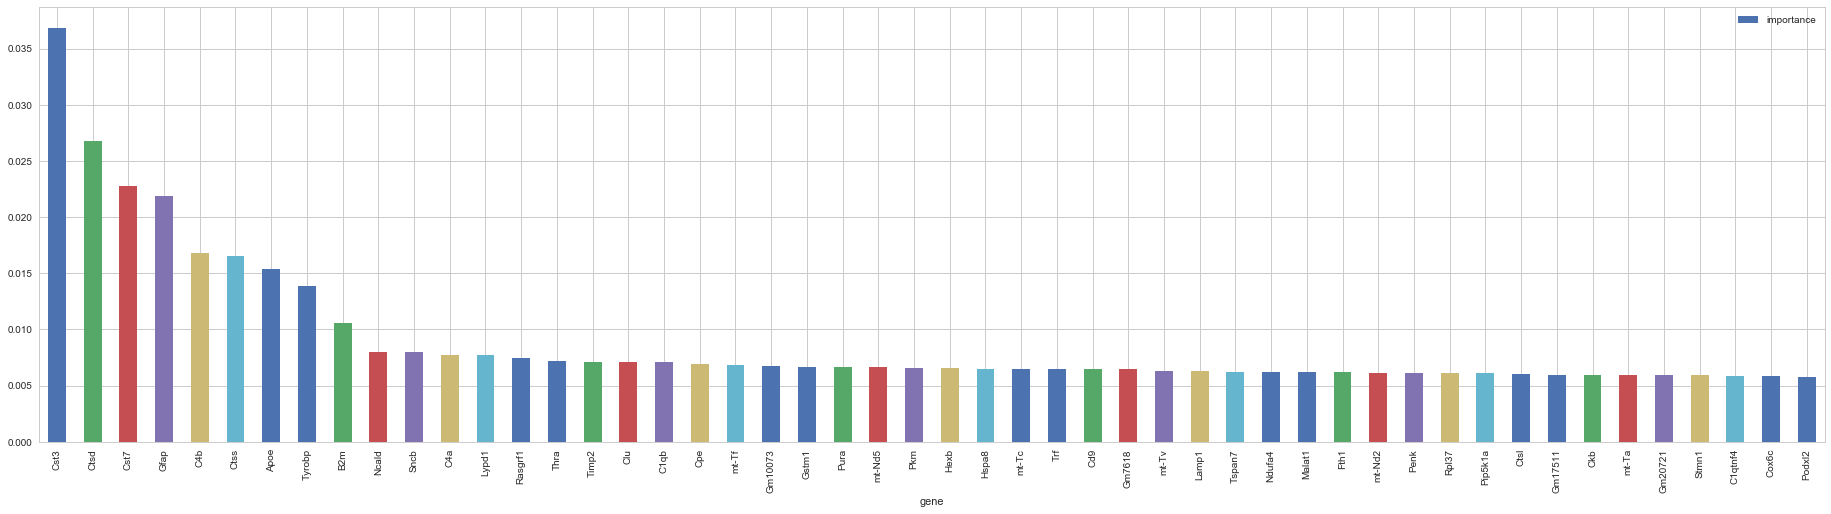

In [28]:
CX_KI_important_genes_df[:50].plot.bar(x='gene', y='importance', figsize=(32, 8))
plt.show()

/home/tmo/work/batiskav/installs/anaconda3/lib/python3.5/site-packages/matplotlib/axes/_axes.py:6448: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/home/tmo/work/batiskav/installs/anaconda3/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


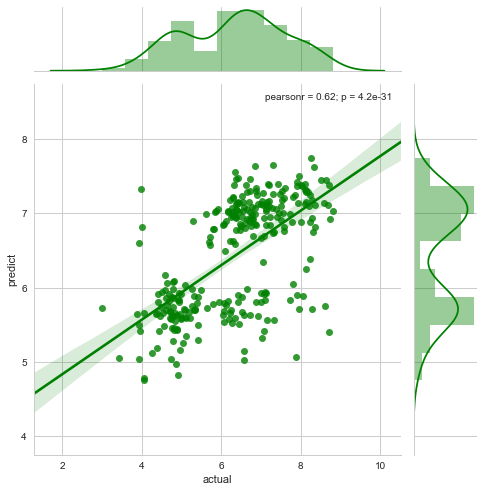

In [29]:
plot_test_predictions(CX_KI_pipeline, CX_KI_X_test, CX_KI_y_test)

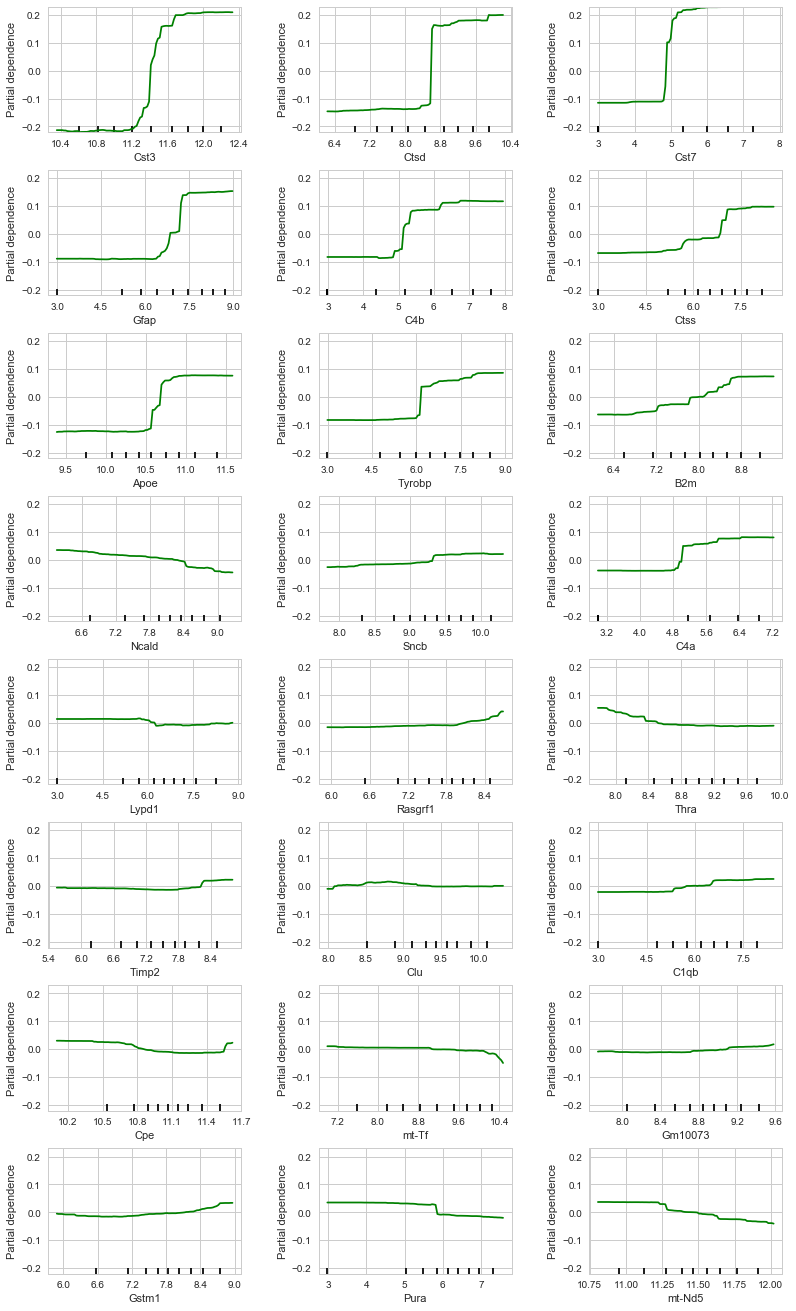

In [51]:
plot_pdp(CX_KI_pipeline, CX_KI_X_train)

---

# BS

In [30]:
(BS_KI_X_train, BS_KI_y_train), (BS_KI_X_test, BS_KI_y_test) = make_datasets(full_df, 'BS', 'KI')

In [ ]:
%%time
BS_KI_pipeline = fit_pipeline(BS_KI_X_train.as_matrix(), 
                              BS_KI_y_train.values.ravel())

In [32]:
BS_KI_boruta_genes, BS_KI_important_genes_df = important_genes(BS_KI_pipeline)

In [84]:
BS_KI_important_genes_df.to_csv('11_results/BS_KI_important_genes.tsv', sep='\t', index=None)

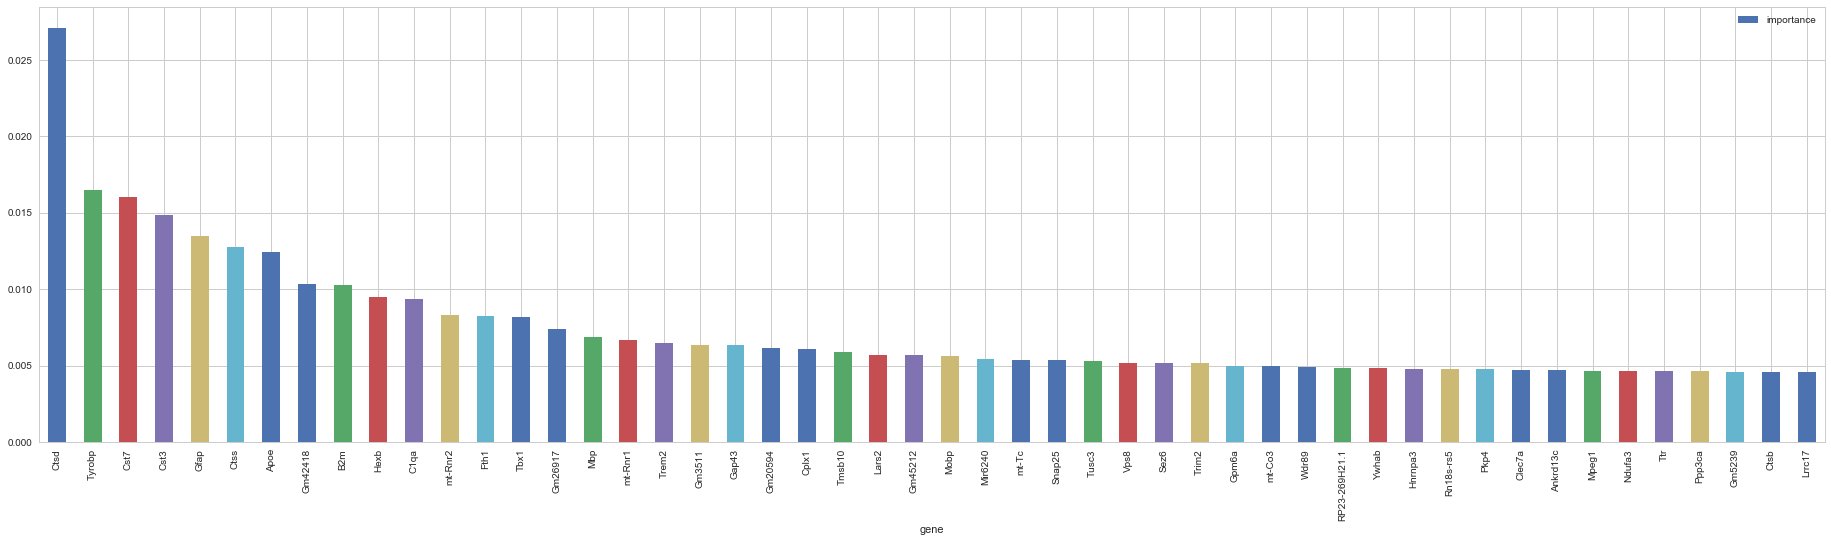

In [33]:
BS_KI_important_genes_df[:50].plot.bar(x='gene', y='importance', figsize=(32, 8))
plt.show()

/home/tmo/work/batiskav/installs/anaconda3/lib/python3.5/site-packages/matplotlib/axes/_axes.py:6448: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/home/tmo/work/batiskav/installs/anaconda3/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


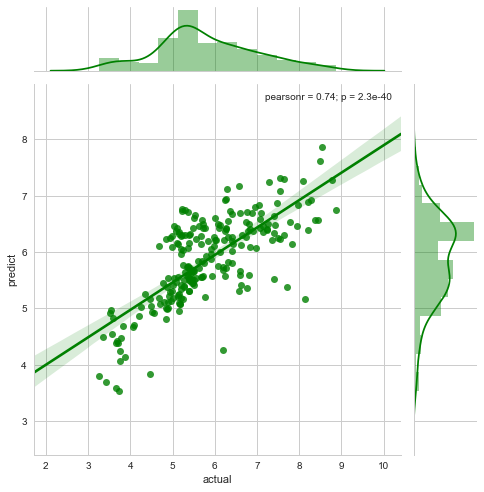

In [34]:
plot_test_predictions(BS_KI_pipeline, BS_KI_X_test, BS_KI_y_test)

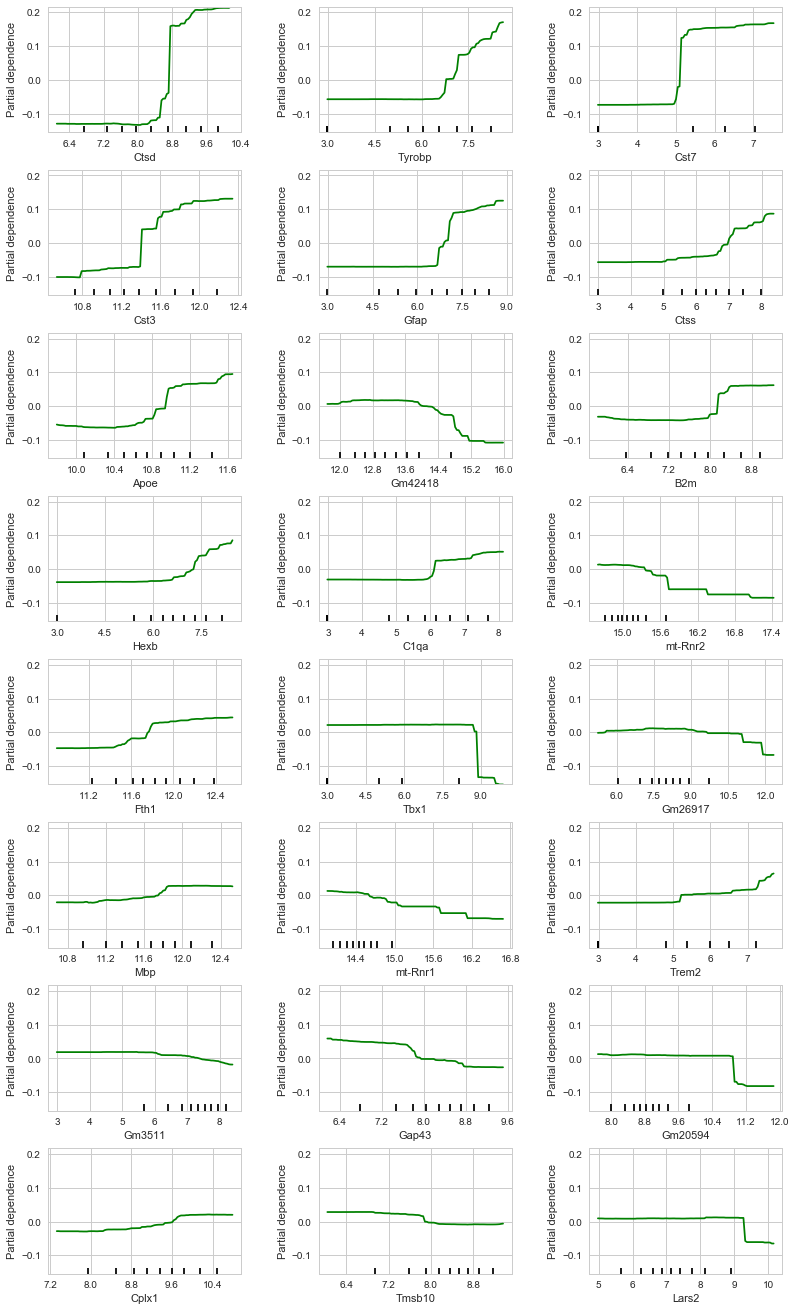

In [52]:
plot_pdp(BS_KI_pipeline, BS_KI_X_train)

---

# HP

In [53]:
(HP_KI_X_train, HP_KI_y_train), (HP_KI_X_test, HP_KI_y_test) = make_datasets(full_df, 'HP', 'KI')

In [ ]:
%%time
HP_KI_pipeline = fit_pipeline(HP_KI_X_train.as_matrix(), 
                              HP_KI_y_train.values.ravel())

In [55]:
HP_KI_boruta_genes, HP_KI_important_genes_df = important_genes(HP_KI_pipeline)

In [85]:
HP_KI_important_genes_df.to_csv('11_results/HP_KI_important_genes.tsv', sep='\t', index=None)

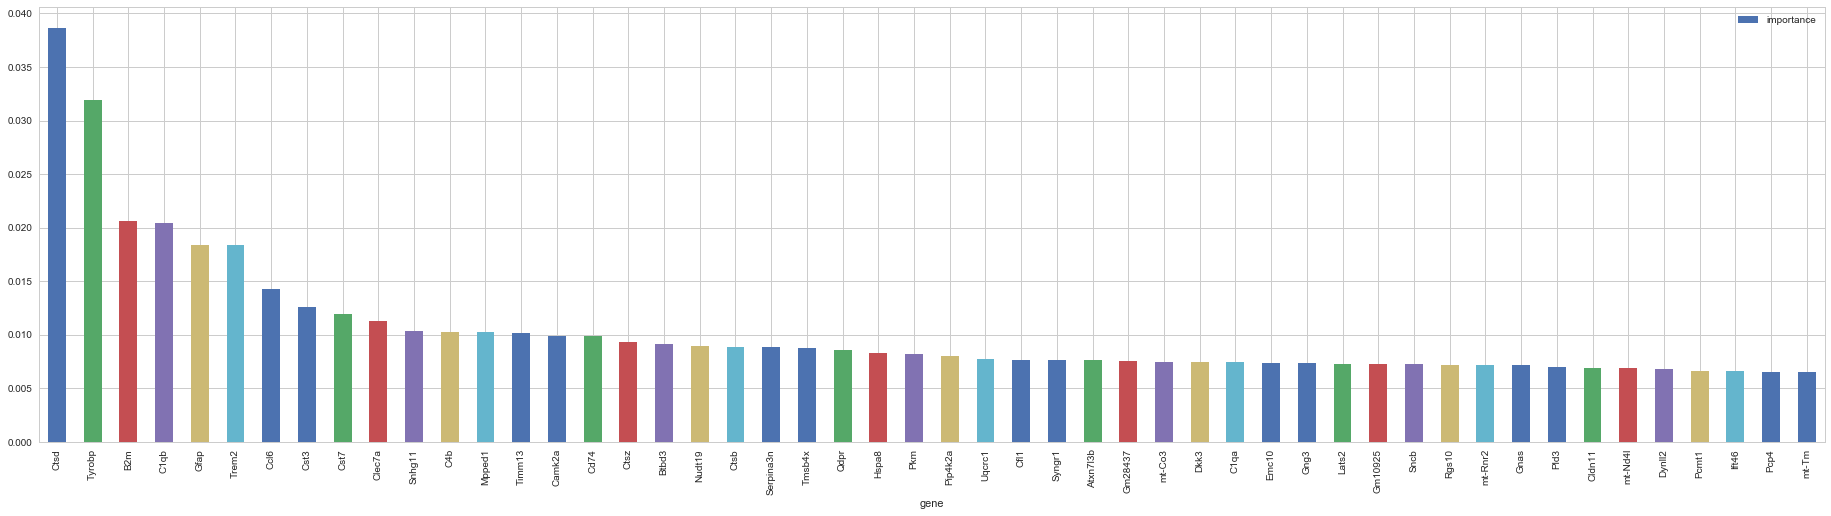

In [56]:
HP_KI_important_genes_df[:50].plot.bar(x='gene', y='importance', figsize=(32, 8))
plt.show()

/home/tmo/work/batiskav/installs/anaconda3/lib/python3.5/site-packages/matplotlib/axes/_axes.py:6448: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/home/tmo/work/batiskav/installs/anaconda3/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


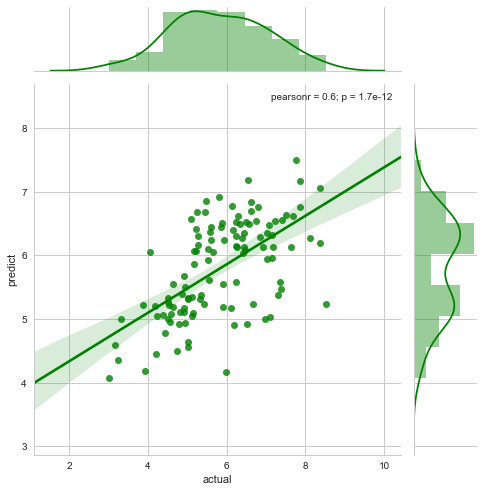

In [57]:
plot_test_predictions(HP_KI_pipeline, HP_KI_X_test, HP_KI_y_test)

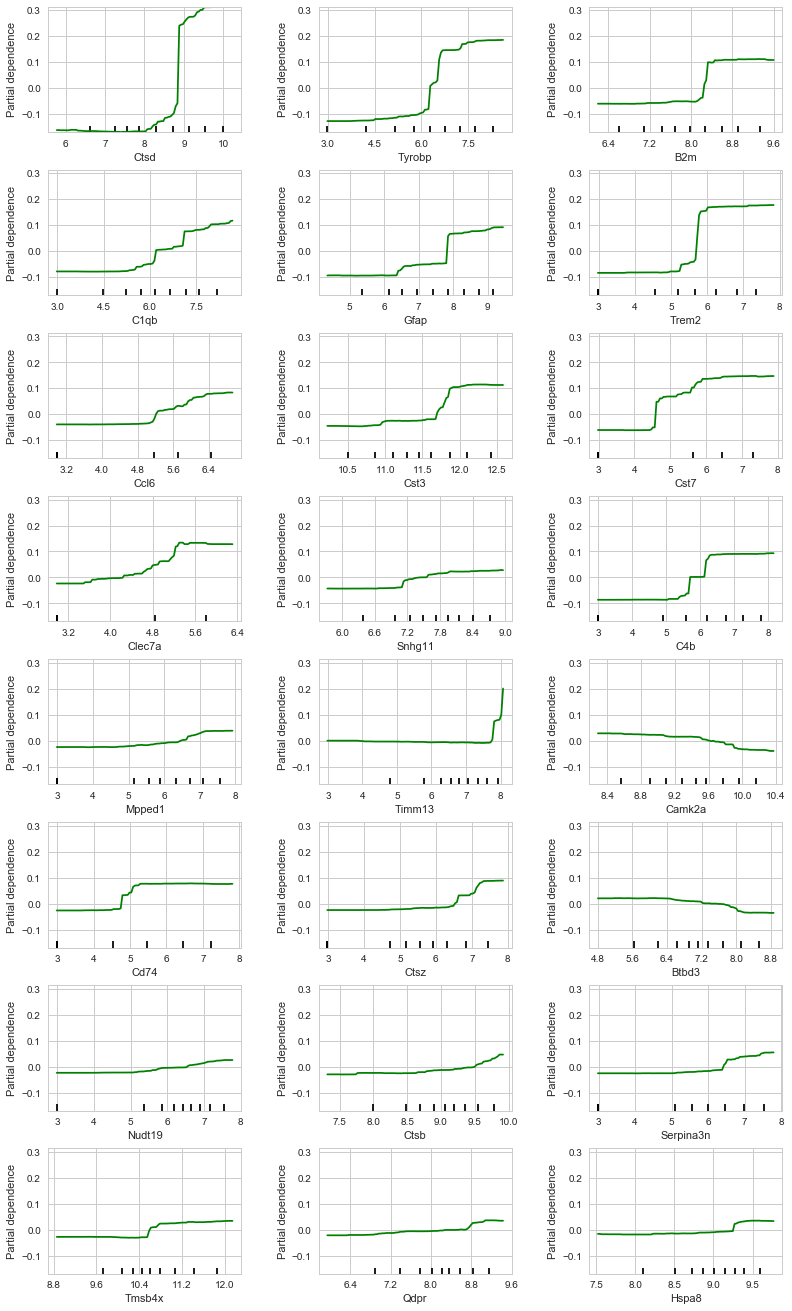

In [73]:
plot_pdp(HP_KI_pipeline, HP_KI_X_train)

---

# ALL level 01 spots

In [67]:
(ALL_KI_X_train, ALL_KI_y_train), (ALL_KI_X_test, ALL_KI_y_test) = make_datasets(full_df, 
                                                                                 level_01_region=None, 
                                                                                 genotype='KI',
                                                                                 groups=full_df[full_df.GT == 'KI']['Level_01'])

In [68]:
%%time
ALL_KI_pipeline = fit_pipeline(ALL_KI_X_train.as_matrix(), 
                               ALL_KI_y_train.values.ravel())

stopped after rounds: 543
CPU times: user 8h 27min 37s, sys: 7min 5s, total: 8h 34min 42s
Wall time: 18min 33s


In [69]:
ALL_KI_boruta_genes, ALL_KI_important_genes_df = important_genes(ALL_KI_pipeline)

In [86]:
ALL_KI_important_genes_df.to_csv('11_results/ALL_KI_important_genes.tsv', sep='\t', index=None)

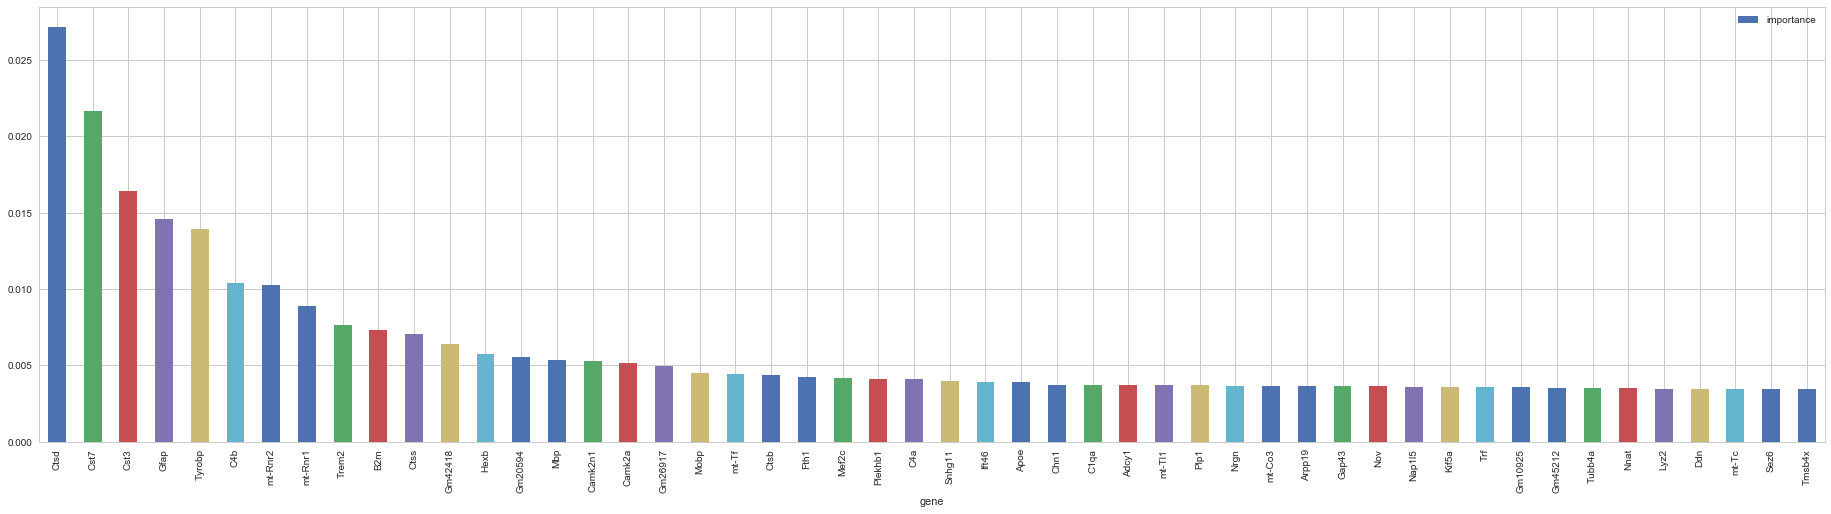

In [70]:
ALL_KI_important_genes_df[:50].plot.bar(x='gene', y='importance', figsize=(32, 8))
plt.show()

/home/tmo/work/batiskav/installs/anaconda3/lib/python3.5/site-packages/matplotlib/axes/_axes.py:6448: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/home/tmo/work/batiskav/installs/anaconda3/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


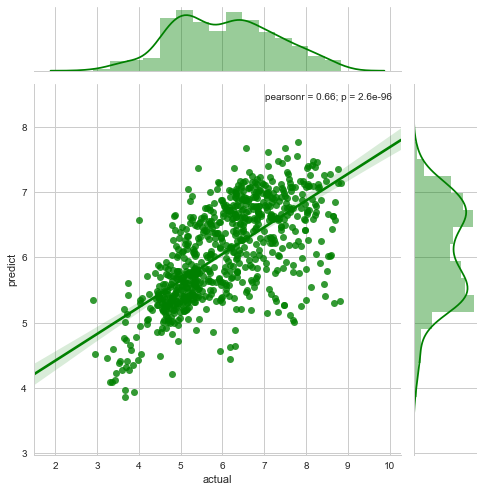

In [71]:
plot_test_predictions(ALL_KI_pipeline, ALL_KI_X_test, ALL_KI_y_test)

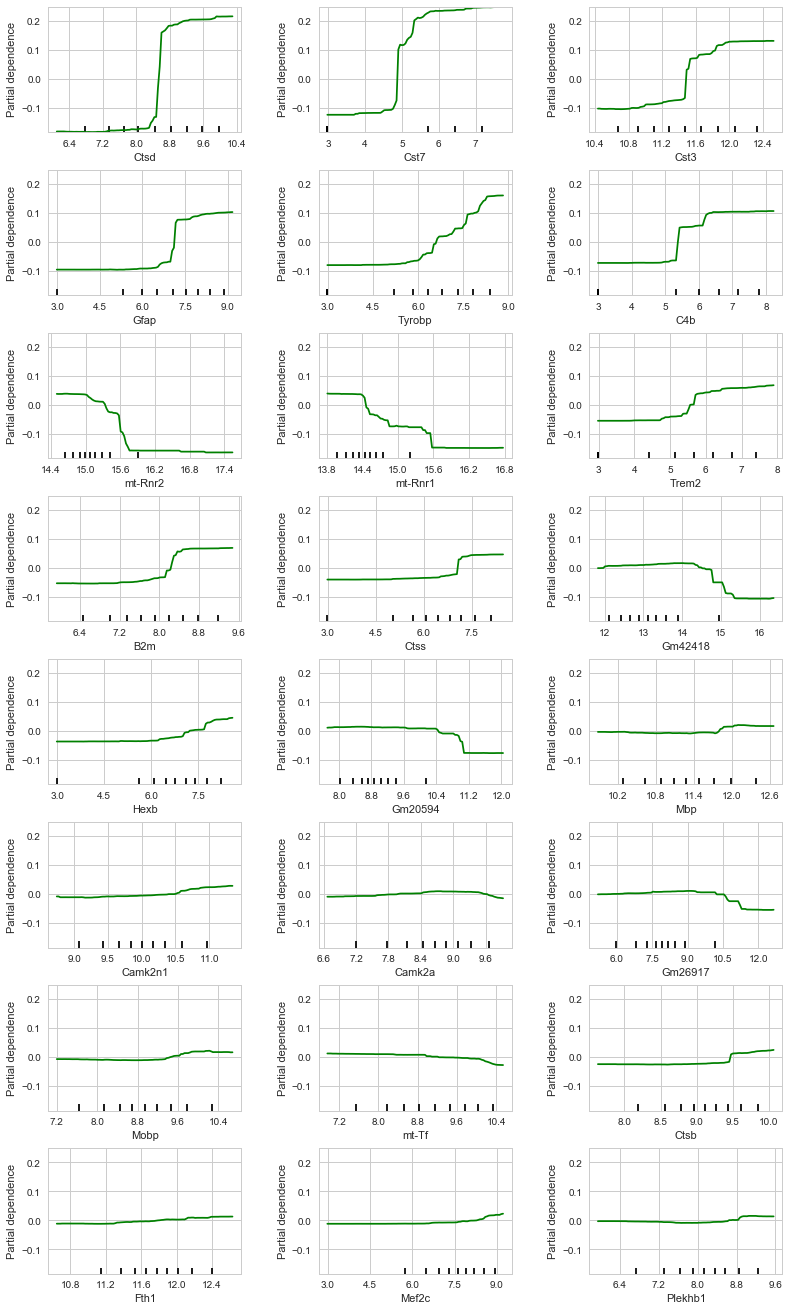

In [72]:
plot_pdp(ALL_KI_pipeline, ALL_KI_X_train)